## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from collections import Counter
import datetime as dt
import numpy as np
import pandas as pd
import pprint, re
import requests
import random
import nltk

In [2]:
# Visualization Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# downloading the universal_tagset from nltk library
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\spk14\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [4]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [5]:
# printing first two sentences of the nltk data
print(nltk_data[:2])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')]]


#### Train Test Split

In [6]:
# setting random state seed
random.seed(1234)

# splitting in to train and test data in 95:5 ratio
train_set, test_set = train_test_split(nltk_data, train_size=0.95, test_size=0.05, random_state=100)

In [7]:
# printing length of train and test data
print("Train data size: ", len(train_set))
print("Test data size: ", len(test_set))

Train data size:  3718
Test data size:  196


In [8]:
# display train data
print("Train data: ", train_set[:3])

Train data:  [[('One', 'NUM'), ('bright', 'ADJ'), ('sign', 'NOUN'), ('is', 'VERB'), ('that', 'ADP'), ('a', 'DET'), ('growing', 'VERB'), ('number', 'NOUN'), ('of', 'ADP'), ('women', 'NOUN'), ('have', 'VERB'), ('entered', 'VERB'), ('the', 'DET'), ('once', 'ADV'), ('male-dominated', 'ADJ'), ('field', 'NOUN'), (';', '.'), ('more', 'ADJ'), ('than', 'ADP'), ('a', 'DET'), ('third', 'ADJ'), ('of', 'ADP'), ('the', 'DET'), ('ringers', 'NOUN'), ('today', 'NOUN'), ('are', 'VERB'), ('women', 'NOUN'), ('.', '.')], [('``', '.'), ('These', 'DET'), ('days', 'NOUN'), (',', '.'), ('banking', 'NOUN'), ('customers', 'NOUN'), ('walk', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('door', 'NOUN'), ('*-1', 'X'), ('expecting', 'VERB'), ('you', 'PRON'), ('to', 'PRT'), ('have', 'VERB'), ('a', 'DET'), ('package', 'NOUN'), ('especially', 'ADV'), ('for', 'ADP'), ('them', 'PRON'), (',', '.'), ("''", '.'), ('Ms.', 'NOUN'), ('Moore', 'NOUN'), ('says', 'VERB'), ('*T*-2', 'X'), ('.', '.')], [('The', 'DET'), ('rights', 'NOUN'

In [9]:
# getting list of tagged words from training set - decompressing list of lists to a single large list
train_tagged_words = [tup for sentence in train_set for tup in sentence]
print(len(train_tagged_words))

95949


In [10]:
# printing first 10 tagged words tuples
print(train_tagged_words[:20])

[('One', 'NUM'), ('bright', 'ADJ'), ('sign', 'NOUN'), ('is', 'VERB'), ('that', 'ADP'), ('a', 'DET'), ('growing', 'VERB'), ('number', 'NOUN'), ('of', 'ADP'), ('women', 'NOUN'), ('have', 'VERB'), ('entered', 'VERB'), ('the', 'DET'), ('once', 'ADV'), ('male-dominated', 'ADJ'), ('field', 'NOUN'), (';', '.'), ('more', 'ADJ'), ('than', 'ADP'), ('a', 'DET')]


In [11]:
# get the tokens from train data set
tokens_train_data = [tup[0] for tup in train_tagged_words]
print(tokens_train_data[:20])

['One', 'bright', 'sign', 'is', 'that', 'a', 'growing', 'number', 'of', 'women', 'have', 'entered', 'the', 'once', 'male-dominated', 'field', ';', 'more', 'than', 'a']


In [12]:
# get unique training vocabulary set
training_vocabulary_set = set(tokens_train_data)
print(len(training_vocabulary_set))

12106


In [13]:
# get the tags from train data set
tags_train_data = [tup[1] for tup in train_tagged_words]
print(tags_train_data[:20])

['NUM', 'ADJ', 'NOUN', 'VERB', 'ADP', 'DET', 'VERB', 'NOUN', 'ADP', 'NOUN', 'VERB', 'VERB', 'DET', 'ADV', 'ADJ', 'NOUN', '.', 'ADJ', 'ADP', 'DET']


In [14]:
# get unique training tag set
training_tag_set = set(tags_train_data)
print(len(training_tag_set))

12


In [15]:
# print the 12 tags of the universal data set 
print(training_tag_set)

{'PRT', 'PRON', 'ADJ', 'ADV', 'CONJ', 'DET', 'ADP', 'VERB', 'X', 'NUM', 'NOUN', '.'}


### Build the vanilla Viterbi based POS tagger

In [16]:
# creating a numpy array of size (tags x vocabulary)
pos_tags_size = len(training_tag_set)
vocab_size = len(training_vocabulary_set)
print(f"Creating matrix of size: {pos_tags_size} x {vocab_size}")
words_given_tag = np.zeros((pos_tags_size, vocab_size))

Creating matrix of size: 12 x 12106


In [17]:
# compute word for given tag: Emission Probability
def word_given_tag(word, tag, train_bag=train_tagged_words):
    """
    Function to compute count of word for given tag for computing Emission probability (word|tag).
    returns: Tuple of word count given tag and the total tag count
    """
    tag_list = [pair for pair in train_bag if pair[1] == tag]
    count_tag = len(tag_list)
    word_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]
    count_word_given_tag = len(word_given_tag_list)
    return (count_word_given_tag, count_tag)

In [18]:
# compute for tag2 given tag1: Transition Probability
def t2_given_t1(t2, t1, train_bag=train_tagged_words):
    """
    Function to compute count of tag t2 for given tag t1 for computing Transition probability (t2|t3).
    returns: Tuple of tag t2 count given tag t1 and the total tag t1 count
    """
    tag_list = [tup[1] for tup in train_tagged_words]
    tags_list_count = Counter(tag_list)
    count_t1 = tags_list_count[t1]
    count_t2_given_t1 = 0
    for index in range(len(tag_list) - 1):
        if tag_list[index] == t1 and tag_list[index+1] == t2:
            count_t2_given_t1 += 1
    return (count_t2_given_t1, count_t1)

In [19]:
# creating transition matrix of tags of size (tags x tags) with columns as t2 and row as t1.
# thus M(i, j) represents P(tj given ti)
tags_matrix = np.zeros((len(training_tag_set), len(training_tag_set)), dtype='float32')

for i, t1 in enumerate(training_tag_set):
    for j, t2 in enumerate(training_tag_set):
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0] / t2_given_t1(t2, t1)[1]

In [20]:
# coverting matrix in to dataframe for better readability
df_tags = pd.DataFrame(tags_matrix, columns=list(training_tag_set), index=list(training_tag_set))
df_tags

,PRT,PRON,ADJ,ADV,CONJ,DET,ADP,VERB,X,NUM,NOUN,.
PRT,0.001969,0.017717,0.083661,0.010171,0.002297,0.101050,0.019357,0.405184,0.013123,0.056102,0.245735,0.043635
PRON,0.012261,0.007663,0.072031,0.034100,0.004981,0.009195,0.023372,0.484291,0.092720,0.007280,0.211494,0.040613
ADJ,0.010156,0.000491,0.067158,0.004914,0.016052,0.004914,0.078624,0.011794,0.020311,0.020803,0.700901,0.063882
ADV,0.014314,0.015646,0.130160,0.077230,0.006991,0.069907,0.119507,0.344541,0.023302,0.031624,0.031624,0.135153
CONJ,0.003709,0.058414,0.118683,0.053778,0.000464,0.118683,0.053778,0.155308,0.008809,0.042188,0.350487,0.035698
DET,0.000240,0.003727,0.204977,0.012623,0.000481,0.005771,0.009618,0.040394,0.045323,0.021640,0.637293,0.017913
ADP,0.001484,0.069119,0.107389,0.013357,0.000848,0.323969,0.017492,0.008481,0.034984,0.061910,0.321213,0.039754
VERB,0.031427,0.035916,0.065640,0.082050,0.005186,0.133292,0.091184,0.168744,0.218438,0.022448,0.111386,0.034291
X,0.184891,0.055705,0.016505,0.025393,0.010316,0.055229,0.144898,0.204571,0.074433,0.002857,0.062371,0.162831
NUM,0.026144,0.001485,0.033571,0.002674,0.013072,0.003862,0.035056,0.016934,0.211824,0.184195,0.352347,0.118835


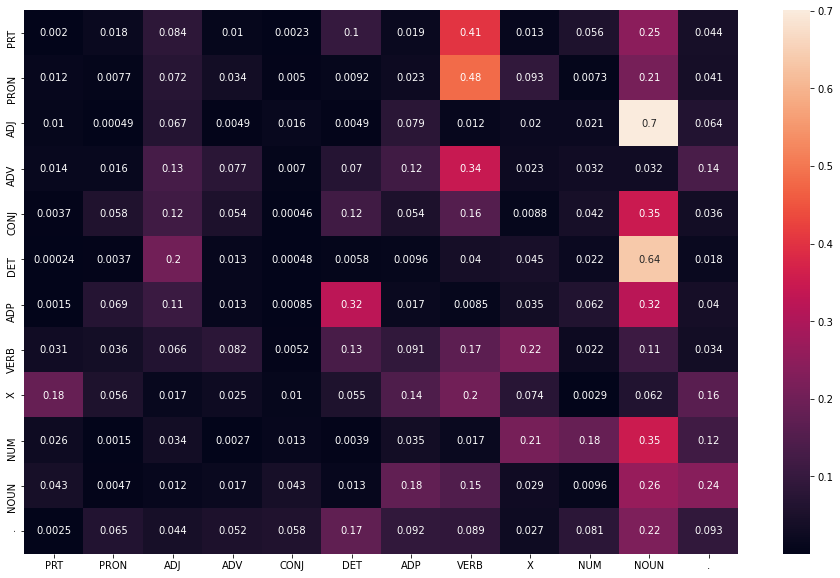

In [21]:
# Heatmap for Tags Matrix: T(i, j) means P(tag j given tag i)
plt.figure(figsize=(16, 10))
sns.heatmap(df_tags, annot=True)
plt.show()

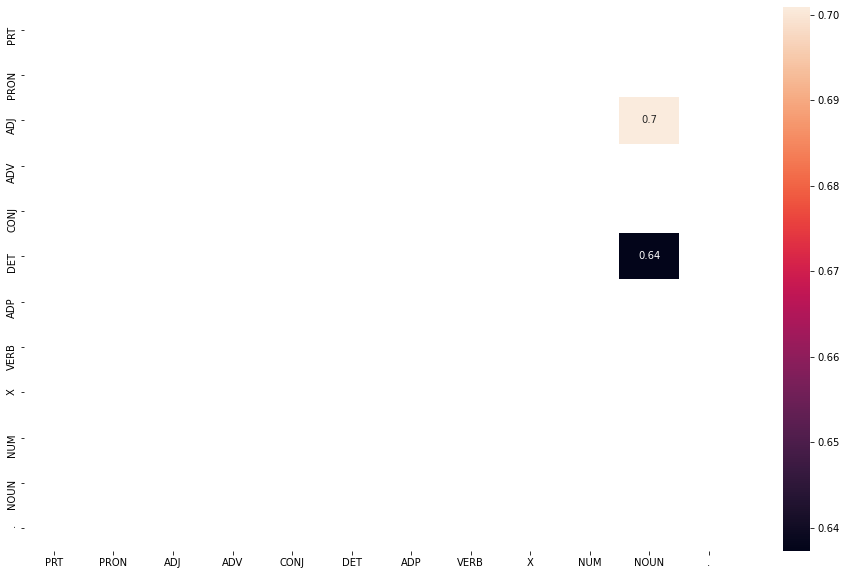

In [22]:
# Heatmap for most frequent tags i.e., filtering df to get P(t2, t1) > 0.5
frequent_tags = df_tags[df_tags > 0.5]

plt.figure(figsize=(16, 10))
sns.heatmap(frequent_tags, annot=True)
plt.show()

We can observe that there is high correlatiob betweeb Noun and Determinant followed by Noun and adjective as expected.
#### POS Tagger based on Viterbi Heuristic

In [23]:
# get length of train data set
len(train_tagged_words)

95949

In [24]:
# Viterbi Heuristic
def vanilla_viterbi(words, train_bag=train_tagged_words):
    """
    Function for POS tagging for give list of words based on Viterbi Heuristic.
    returns: Tagged list of words
    """
    state = []
    tag_list = list(set([tup[1] for tup in train_bag]))
    
    for key, word in enumerate(words):
        # initialize list of probability column for a given observation/word
        p = []
        for tag in tag_list:
            if key == 0:
                transition_p = df_tags.loc['.', tag]
            else:
                transition_p = df_tags.loc[state[-1], tag]
                
            # computing emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0] / word_given_tag(words[key], tag)[1]
            state_p = emission_p * transition_p
            p.append(state_p)
            
        p_max = max(p)
        # getting state for which probability is maximum
        state_max = tag_list[p.index(p_max)]
        state.append(state_max)
    return list(zip(words, state))

In [25]:
# setting random seed
random.seed(1234)

# Testing Viterbi algorithm on test data set
test_run_base = [tup for sentence in test_set for tup in sentence]

# getting list of untagged words from test set
test_tagged_words = [tup[0] for sentence in test_set for tup in sentence]

In [26]:
# get size of test run base and test tagged words
print(f"The size of Test Run Base: {len(test_run_base)}")
print(f"The size of Test Tagged Words: {len(test_tagged_words)}")

The size of Test Run Base: 4727
The size of Test Tagged Words: 4727


In [27]:
# Tagging test sentences using Vanilla Viterbi
start_time = dt.datetime.now()
tagged_seq = vanilla_viterbi(test_tagged_words)
end_time = dt.datetime.now()
time_diff = end_time - start_time

In [28]:
# Time taken by Vanilla Viterbi
print(f"Time taken by Vanilla Viterbi algorithm: {time_diff}")

Time taken by Vanilla Viterbi algorithm: 0:40:07.888294


In [29]:
# checking accuracy of the model
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
vanilla_viterbi_accuracy = len(check) / len(tagged_seq)
print(f"Accuracy of Vanilla Viterbi Heuristic: {vanilla_viterbi_accuracy: 0.4f}")

Accuracy of Vanilla Viterbi Heuristic:  0.9027


In [30]:
# getting incorrectly tagged sentences from the test set
incorrect_tagged_cases = [[test_run_base[i-1], j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]
len(incorrect_tagged_cases)

460

In [31]:
print(incorrect_tagged_cases[:10])

[[('to', 'PRT'), (('book', 'NOUN'), ('book', 'VERB'))], [('leaving', 'VERB'), (('stocks', 'NOUN'), ('stocks', 'ADV'))], [('stocks', 'ADV'), (('up', 'PRT'), ('up', 'ADP'))], [('carried', 'VERB'), (('over', 'ADP'), ('over', 'PRT'))], [('apparently', 'ADV'), (('ignored', 'PRT'), ('ignored', 'VERB'))], [('Chilean', 'ADJ'), (('mine', 'NOUN'), ('mine', 'ADJ'))], [('the', 'DET'), (('Palestinian', 'ADJ'), ('Palestinian', 'NOUN'))], [('committee', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))], [('.', '.'), (('Preston', 'PRT'), ('Preston', 'NOUN'))], [('Foster', 'NOUN'), (('Birmingham', 'PRT'), ('Birmingham', 'NOUN'))]]


Checking unknown words from the test set.

In [32]:
# Checking for unknown words
test_vocabulary_set = set([word for word in test_tagged_words])
unknown_word_list = list(test_vocabulary_set - training_vocabulary_set)
print(f"Number of unknown words: {len(unknown_word_list)}")

Number of unknown words: 302


In [33]:
print(unknown_word_list[:50])

['forest-product', 'Californian', 'smiles', 'NCNB', 'broadly', 'Ketchum', 'curbed', 'Wick', 'Video', '240-page', 'Paper', 'illustrates', 'Trans', 'purhasing', '59-year-old', 'Nylev', '89.7', 'Louisiana-Pacific', 'Tots', 'shown', 'Somerset', 'Four', 'Corazon', '*-154', 'dust-up', 'Brussels', '858,000', 'blinks', 'Metal', 'diagnosed', 'burned', 'infectious', 'underprivileged', 'fuels', 'Kelli', 'dreamed', 'executive-office', 'broadened', 'loose', 'polyproplene', '115', 'intervention', 'DeFazio', 'money-losing', 'Left', '472', 'Sit', '*-58', 'GROWTH', 'fifth-largest']


### Solve the problem of unknown words
With the Vanilla Viterbi algorithm, we achieved an accuracy of about __90.27%__. The approximate 9% loss of accuracy was mainly due to the the algorithm encountering unknown words which were not present in the training dataset. <br>
An arbitrary tag was assigned for unknown words due to the fact that emission probabilities for unknown words are 0. Hence the algorithm chooses the first tag (arbitrarily) for the encountered unknown words. 
#### Method 1
We can modify the vanilla viterbi algorithm to minimize the loss of accuracy.<br>
Since the word is absent in training dataset, the emission probability is 0 and in turn state probability is also 0. In this case, when an unknown word is encountered, we can consider only transition and ignore emission probability. <br>
The algorithm is modified to deal with unknown words by considering only transition probability (since emission probability is 0) else both emission and transition probabilities.

In [34]:
# modifying the vanilla viterbi to deal with unknown words
def modified_viterbi_for_unknown_words(words, train_bag=train_tagged_words):
    """
    Function to tag words using modified viterbi algorithm to deal with unknown words in dataset.
    returns: Tagged list of words
    """
    state = []
    tag_list = list(set([tup[1] for tup in train_bag]))
    
    for key, word in enumerate(words):
        # initialize list of probability column for a given observation/word
        p = []
        for tag in tag_list:
            if key == 0:
                transition_p = df_tags.loc['.', tag]
            else:
                transition_p = df_tags.loc[state[-1], tag]
            
            # computing emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0] / word_given_tag(words[key], tag)[1]
            
            # modification to deal with unknown words
            if word not in training_vocabulary_set:
                state_p = transition_p
            else:
                state_p = emission_p * transition_p
            p.append(state_p)
            
        p_max = max(p)
        # getting state for which probability is maximum
        state_max = tag_list[p.index(p_max)]
        state.append(state_max)
    return list(zip(words, state))

In [35]:
# Tagging test sentences using Modified Viterbi
start_time = dt.datetime.now()
tagged_seq_unknown_words = modified_viterbi_for_unknown_words(test_tagged_words)
end_time = dt.datetime.now()
time_diff = end_time - start_time

In [36]:
# Time taken by Modified Vanilla Viterbi algorithm
print(f"Time taken by Modified Vanilla Viterbi algorithm: {time_diff}")

Time taken by Modified Vanilla Viterbi algorithm: 0:33:38.219941


In [37]:
# checking accuracy of the model
check_unknown_words = [i for i, j in zip(tagged_seq_unknown_words, test_run_base) if i == j]
modified_viterbi_accuracy = len(check_unknown_words) / len(tagged_seq_unknown_words)
print(f"Accuracy of Modified Vanilla Viterbi Heuristic: {modified_viterbi_accuracy: 0.4f}")

Accuracy of Modified Vanilla Viterbi Heuristic:  0.9331


We can observe the after modification of the Vanilla Viterbi algorithm, the accuracy is __93.31%__.<br>
This indicates that the modified viterbi algorithm performs better than the vanilla viterbi.<br>
There is an __improvement from 90.27% (vanilla viterbi) to 93.31% (modified viterbi)__.

##### Lexicon and Rule Based POS Taggers
We still observe a loss of accuracy of approx 6%. <br>
###### Unigram POS Tagger

In [38]:
# creating an unigram tagger
unigram_tagger = nltk.UnigramTagger(train=train_set)

In [39]:
# Tagging test sentences using Unigram Tagger
start_time = dt.datetime.now()
unigram_tagger_accuracy = unigram_tagger.evaluate(test_set)
end_time = dt.datetime.now()
time_diff = end_time - start_time

In [40]:
# Time taken by Unigram Tagger
print(f"Time taken by Unigram Tagger: {time_diff}")

Time taken by Unigram Tagger: 0:00:00.021837


In [41]:
# checking accuracy of Unigram Tagger
print(f"Accuracy of Unigram Tagger: {unigram_tagger_accuracy: 0.4f}")

Accuracy of Unigram Tagger:  0.9014


Combining Unigram Tagger with Rule based Tagger

In [42]:
# pattern for rule based pos tagging based on regex
patterns = [
    (r'.*\'s$', 'NOUN'),                     # possessive nouns
    (r'.*s$', 'NOUN'),                       # plural nouns
    (r'.*ness$', 'NOUN'),                    # nouns formed from adjectives
    (r'.*', 'NOUN'),                         # nouns
    (r'^[aA-zZ].*[0-9]+','NOUN'),            # Alphanumeric as nouns
    (r'.*ing$', 'VERB'),                     # gerund
    (r'.*ed$', 'VERB'),                      # past tense verbs
    (r'.*es$', 'VERB'),                      # singular present verbs
    (r'.*ould$', 'VERB'),                    # modal verbs
    (r'.*able$', 'ADJ'),                     # adjectives
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'), # adjectives with hyphenated words
    (r'.*ly$', 'ADV'),                       # adverbs
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),        # cardinal numbers
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # articles or determinants  
]

In [43]:
# creating rule based regex tagger
rule_based_regex_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed by rule based regex tagger
regex_rule_based_unigram_tagger = nltk.UnigramTagger(train=train_set, backoff=rule_based_regex_tagger)

In [44]:
# Tagging test sentences using Unigram Tagger backed by Rule based tagger
start_time = dt.datetime.now()
regex_rule_unigram_tagger_accuracy = regex_rule_based_unigram_tagger.evaluate(test_set)
end_time = dt.datetime.now()
time_diff = end_time - start_time

In [45]:
# Time taken by Unigram Tagger backed by Rule based Regex Tagger
print(f"Time taken by Unigram Tagger backed by Rule based Regex Tagger: {time_diff}")

# checking accuracy of Unigram Tagger backed by Rule based Regex Tagger
print(f"Accuracy of Unigram Tagger backed by Rule based Regex Tagger: {regex_rule_unigram_tagger_accuracy: 0.4f}")

Time taken by Unigram Tagger backed by Rule based Regex Tagger: 0:00:00.028645
Accuracy of Unigram Tagger backed by Rule based Regex Tagger:  0.9334


###### Bigram POS Tagger
Creating a bigram tagger backed by rule based unigram tagger.

In [46]:
# creating a bigram tagger backed with unigram tagger
bigram_tagger = nltk.BigramTagger(train=train_set, backoff=regex_rule_based_unigram_tagger)

In [47]:
# Tagging test sentences using Bigram Tagger backed by Rule based Unigram tagger
start_time = dt.datetime.now()
bigram_tagger_accuracy = bigram_tagger.evaluate(test_set)
end_time = dt.datetime.now()
time_diff = end_time - start_time

In [48]:
# Time taken by Bigram Tagger
print(f"Time taken by Bigram Tagger backed by Rule based Unigram tagger: {time_diff}")

# checking accuracy of Bigram Tagger
print(f"Accuracy of Bigram Tagger backed by Rule based Unigram tagger: {bigram_tagger_accuracy: 0.4f}")

Time taken by Bigram Tagger backed by Rule based Unigram tagger: 0:00:00.027156
Accuracy of Bigram Tagger backed by Rule based Unigram tagger:  0.9363


###### Trigram POS Tagger
Creating a trigram tagger backed by bigram tagger.

In [49]:
# creating a trigram tagger backed with bigram tagger
trigram_tagger = nltk.TrigramTagger(train=train_set, backoff=bigram_tagger)

In [50]:
# Tagging test sentences using Trigram Tagger backed by Bigram tagger
start_time = dt.datetime.now()
trigram_tagger_accuracy = trigram_tagger.evaluate(test_set)
end_time = dt.datetime.now()
time_diff = end_time - start_time

In [51]:
# Time taken by Trigram Tagger
print(f"Time taken by Trigram Tagger backed by Bigram tagger: {time_diff}")

# checking accuracy of Trigram Tagger
print(f"Accuracy of Trigram Tagger backed by Bigram tagger: {trigram_tagger_accuracy: 0.4f}")

Time taken by Trigram Tagger backed by Bigram tagger: 0:00:00.034844
Accuracy of Trigram Tagger backed by Bigram tagger:  0.9378


#### Method 2
We can observe that trigram tagger backed by the bigram tagger as a backoff gives us an accuracy of __93.78%__.<br>
Hence modifying the viterbi to use trigram tagger backed by rule based regex tagger as the backoff.

In [68]:
# creating a trigram tagger backed by the bigram tagger
def rule_based_trigram_tagger(word, train_data=train_set):
    """
    Function to generate tags using trigram tagger backed by rule based regex tagger.
    returns: Tag for the given word
    """
    patterns = [
        (r'.*\'s$', 'NOUN'),                     # possessive nouns
        (r'.*s$', 'NOUN'),                       # plural nouns
        (r'.*ness$', 'NOUN'),                    # nouns formed from adjectives
        (r'.*', 'NOUN'),                         # nouns
        (r'^[aA-zZ].*[0-9]+','NOUN'),            # Alphanumeric as nouns
        (r'.*ing$', 'VERB'),                     # gerund
        (r'.*ed$', 'VERB'),                      # past tense verbs
        (r'.*es$', 'VERB'),                      # singular present verbs
        (r'.*ould$', 'VERB'),                    # modal verbs
        (r'.*able$', 'ADJ'),                     # adjectives
        (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'), # adjectives with hyphenated words
        (r'.*ly$', 'ADV'),                       # adverbs
        (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),        # cardinal numbers
        (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # articles or determinants  
    ]
    regex_based_tagger = nltk.RegexpTagger(patterns)
    # creating trigram tagger backed by rule based regex tagger
    regex_backed_trigram_tagger = nltk.TrigramTagger(train=train_data, backoff=regex_based_tagger)
    return regex_backed_trigram_tagger.tag_sents([[(word)]])

In [71]:
# modifying viterbi to use trigram tagger as backoff
def trigram_backed_viterbi(words, train_bag=train_tagged_words):
    """
    Function to tag given words using trigram tagger backed viterbi algorithm.
    returns: Tag list for given words
    """
    state = []
    tag_list = list(set([tup[1] for tup in train_bag]))
    
    # using rule based trigram tagger for dealing with unknown words
    for key, word in enumerate(words):
        p = []
        for tag in tag_list:
            if key == 0:
                transition_p = df_tags.loc['.', tag]
            else:
                transition_p = df_tags.loc[state[-1], tag]
            
            # computing emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0] / word_given_tag(words[key], tag)[1]
            state_p = emission_p * transition_p
            p.append(state_p)
            
        p_max = max(p)
        # check for unknown words and deal by using regex based trigram tagger
        if p_max == 0:
            state_max = rule_based_trigram_tagger(word)[0][0][1]
            if state_max is None:
                state_max = '.'
        else:
            # getting state for which probability is maximum
            state_max = tag_list[p.index(p_max)]
        state.append(state_max)
    return list(zip(words, state))

In [72]:
# Tagging test sentences using Trigram tagger backed Viterbi
start_time = dt.datetime.now()
trigram_viterbi_tagged_seq = trigram_backed_viterbi(test_tagged_words)
end_time = dt.datetime.now()
time_diff = end_time - start_time

In [73]:
# Time taken by Trigram tagger backed Viterbi
print(f"Time taken by Rule based Trigram tagger backed Viterbi algorithm: {time_diff}")

Time taken by Rule based Trigram tagger backed Viterbi algorithm: 0:22:34.582189


#### Evaluating tagging accuracy

In [74]:
# checking accuracy of the Trigram tagger backed Viterbi model
trigram_viterbi_check = [i for i, j in zip(trigram_viterbi_tagged_seq, test_run_base) if i == j]
trigram_viterbi_accuracy = len(trigram_viterbi_check) / len(trigram_viterbi_tagged_seq)
print(f"Accuracy of Rule based Trigram tagger backed Viterbi Heuristic: {trigram_viterbi_accuracy: 0.4f}")

Accuracy of Rule based Trigram tagger backed Viterbi Heuristic:  0.9348


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm
##### Comparing accuracy of vanilla viterbi with modifications of viterbi algorithm using train test split data.

In [75]:
# collecting all accuracies
accuracy_data = [
    ['Vanilla Viterbi', vanilla_viterbi_accuracy * 100], 
    ['Modified Vanilla Viterbi', modified_viterbi_accuracy * 100], 
    ['Unigram Tagger', unigram_tagger_accuracy * 100],
    ['Unigram Tagger + Regexp_Tagger', regex_rule_unigram_tagger_accuracy * 100],
    ['Bigram Tagger + Unigram_tagger', bigram_tagger_accuracy * 100],
    ['Trigram Tagger + Bigram_tagger', trigram_tagger_accuracy * 100],
    ['Viterbi + Trigram_tagger', trigram_viterbi_accuracy * 100]
]

In [76]:
# creating a dataframe with accuracies of all the models
df_acccuracy_data = pd.DataFrame(accuracy_data, columns=['Tagging_Algorithm', 'Tagging_Accuracy'])
df_acccuracy_data.set_index('Tagging_Algorithm', drop=True, inplace=True)
df_acccuracy_data

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,90.268669
Modified Vanilla Viterbi,93.314999
Unigram Tagger,90.141739
Unigram Tagger + Regexp_Tagger,93.336154
Bigram Tagger + Unigram_tagger,93.632325
Trigram Tagger + Bigram_tagger,93.780410
Viterbi + Trigram_tagger,93.484239


##### Evaluating accuracy with provided sample text data

In [78]:
# reading Test_sentences file to evaluate the created models
with open('Test_sentences.txt') as file:
    text = file.read()
    sample_text = text.splitlines()
sample_text

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [79]:
# removing blank sentences or empty spaces
sample_sentences = [text for text in sample_text if text != '']
sample_sentences

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [80]:
sample_sentence_tokenized = [word_tokenize(text) for text in sample_sentences]
sample_sentence_corpus_pos_tags = nltk.pos_tag_sents(sample_sentence_tokenized, tagset='universal')
print(sample_sentence_corpus_pos_tags)

[[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')], [('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')], [('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')], [('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DE

In [82]:
# list of untagged words from the sample test data provided
sample_sentence_tagged_words = [tup[0] for sentence in sample_sentence_corpus_pos_tags for tup in sentence]
print("sample_sentence_tagged_words: ", sample_sentence_tagged_words, '\n')

# list of tagged words
sample_sentence_test_run_base = [tup for sentence in sample_sentence_corpus_pos_tags for tup in sentence]
print("sample_sentence_test_run_base: ", sample_sentence_test_run_base)

sample_sentence_tagged_words:  ['Android', 'is', 'a', 'mobile', 'operating', 'system', 'developed', 'by', 'Google', '.', 'Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 'smartphones', 'since', '2011', 'and', 'on', 'tablets', 'since', '2013', '.', 'Google', 'and', 'Twitter', 'made', 'a', 'deal', 'in', '2015', 'that', 'gave', 'Google', 'access', 'to', 'Twitter', "'s", 'firehose', '.', 'Twitter', 'is', 'an', 'online', 'news', 'and', 'social', 'networking', 'service', 'on', 'which', 'users', 'post', 'and', 'interact', 'with', 'messages', 'known', 'as', 'tweets', '.', 'Before', 'entering', 'politics', ',', 'Donald', 'Trump', 'was', 'a', 'domineering', 'businessman', 'and', 'a', 'television', 'personality', '.', 'The', '2018', 'FIFA', 'World', 'Cup', 'is', 'the', '21st', 'FIFA', 'World', 'Cup', ',', 'an', 'international', 'football', 'tournament', 'contested', 'once', 'every', 'four', 'years', '.', 'This', 'is', 'the', 'first', 'World', 'Cup', 'to', 'be', 'held', 'i

#### Testing the accuracy of Vanilla Viterbi Tagger on sample test data

In [83]:
# Tagging sample test sentences using Vanilla Viterbi
start_time = dt.datetime.now()
sample_sent_tagged_seq = vanilla_viterbi(sample_sentence_tagged_words)
end_time = dt.datetime.now()
time_diff = end_time - start_time

In [84]:
# Time taken by Vanilla Viterbi
print(f"Time taken by Vanilla Viterbi algorithm: {time_diff}")

Time taken by Vanilla Viterbi algorithm: 0:00:41.098969


In [85]:
# checking accuracy of the model
sample_test_check = [i for i, j in zip(sample_sent_tagged_seq, sample_sentence_test_run_base) if i == j]
sample_data_vanilla_viterbi_accuracy = len(sample_test_check) / len(sample_sent_tagged_seq)
print(f"Accuracy of Vanilla Viterbi Heuristic: {sample_data_vanilla_viterbi_accuracy: 0.4f}")

Accuracy of Vanilla Viterbi Heuristic:  0.7569


#### Testing the accuracy of Modified Vanilla Viterbi Tagger on sample test data

In [86]:
# Tagging sample test sentences using Modified Viterbi
start_time = dt.datetime.now()
sample_sent_tagged_seq_unknown_words = modified_viterbi_for_unknown_words(sample_sentence_tagged_words)
end_time = dt.datetime.now()
time_diff = end_time - start_time

In [87]:
# Time taken by Modified Vanilla Viterbi algorithm
print(f"Time taken by Modified Vanilla Viterbi algorithm: {time_diff}")

Time taken by Modified Vanilla Viterbi algorithm: 0:00:46.831062


In [88]:
# checking accuracy of the model
sample_data_check_unknown_words = [i for i, j in zip(sample_sent_tagged_seq_unknown_words, sample_sentence_test_run_base) if i == j]
sample_data_modified_viterbi_accuracy = len(sample_data_check_unknown_words) / len(sample_sent_tagged_seq_unknown_words)
print(f"Accuracy of Modified Vanilla Viterbi Heuristic: {sample_data_modified_viterbi_accuracy: 0.4f}")

Accuracy of Modified Vanilla Viterbi Heuristic:  0.8619


#### Testing the accuracy of Rule based Trigram backed Vanilla Viterbi Tagger on sample test data

In [89]:
# Tagging sample test sentences using Trigram tagger backed Viterbi
start_time = dt.datetime.now()
sample_data_trigram_viterbi_tagged_seq = trigram_backed_viterbi(sample_sentence_tagged_words)
end_time = dt.datetime.now()
time_diff = end_time - start_time

In [90]:
# Time taken by Trigram tagger backed Viterbi
print(f"Time taken by Rule based Trigram tagger backed Viterbi algorithm: {time_diff}")

Time taken by Rule based Trigram tagger backed Viterbi algorithm: 0:01:26.155486


In [92]:
# checking accuracy of the Trigram tagger backed Viterbi model
sample_data_trigram_viterbi_check = [i for i, j in zip(sample_data_trigram_viterbi_tagged_seq, sample_sentence_test_run_base) if i == j]
sample_data_trigram_viterbi_accuracy = len(sample_data_trigram_viterbi_check) / len(sample_data_trigram_viterbi_tagged_seq)
print(f"Accuracy of Rule based Trigram tagger backed Viterbi Heuristic: {sample_data_trigram_viterbi_accuracy: 0.4f}")

Accuracy of Rule based Trigram tagger backed Viterbi Heuristic:  0.9061


#### Comparing accuracies of these 3 models on Sample Test Data

In [93]:
# collecting accuracies of models on sample test data
sample_data_accuracy = [
    ['Vanilla Viterbi', sample_data_vanilla_viterbi_accuracy * 100], 
    ['Modified Vanilla Viterbi', sample_data_modified_viterbi_accuracy * 100], 
    ['Viterbi + Trigram_tagger', sample_data_trigram_viterbi_accuracy * 100]
]

In [94]:
# creating dataframe of accuracies of models for sample test data
df_sample_data_accuracy = pd.DataFrame(sample_data_accuracy, columns =['Tagging_Algorithm', 'Tagging_Accuracy'])
df_sample_data_accuracy.set_index('Tagging_Algorithm', drop=True, inplace=True)
df_sample_data_accuracy

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,75.690608
Modified Vanilla Viterbi,86.187845
Viterbi + Trigram_tagger,90.607735


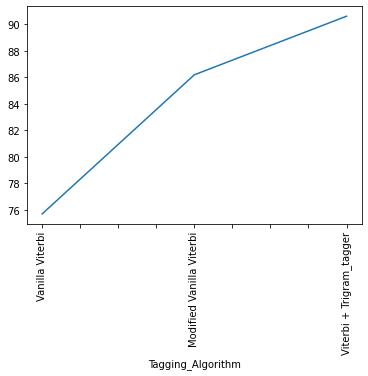

In [96]:
# plotting accuracy of models on sample test data
df_sample_data_accuracy.plot.line(rot=90, legend=False)
plt.show()

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [97]:
# test sentences
test_sent_1 = 'Android is a mobile operating system developed by Google.'
test_sent_2 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
test_sent_3 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."
test_sent_4 = 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
test_sent_5 = 'Before entering politics, Donald Trump was a domineering businessman and a television personality.'
test_sent_6 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
test_sent_7 = 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.'
test_sent_8 = 'Show me the cheapest round trips from Dallas to Atlanta'
test_sent_9 = 'I would like to see flights from Denver to Philadelphia.'
test_sent_10 = 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.'
test_sent_11 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'

##### Case 1

In [98]:
# using test_sent_2
words_test_sent_2 = nltk.word_tokenize(test_sent_2)

In [100]:
# Tagging using Vanilla Viterbi
tagged_seq_with_vanilla_viterbi_2 = vanilla_viterbi(words_test_sent_2)
print("Tagging sequence with Vanilla Viterbi model - \n", tagged_seq_with_vanilla_viterbi_2)

Tagging sequence with Vanilla Viterbi model - 
 [('Android', 'PRT'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'PRT'), ('worldwide', 'PRT'), ('on', 'ADP'), ('smartphones', 'PRT'), ('since', 'ADP'), ('2011', 'PRT'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'PRT'), ('.', '.')]


In [102]:
# Tagging with Trigram tagger backed Viterbi model
tagged_seq_with_viterbi_trigram_2 = trigram_backed_viterbi(words_test_sent_2)
print("Tagging sequence with Trigram tagger backed Viterbi model -\n", tagged_seq_with_viterbi_trigram_2)

Tagging sequence with Trigram tagger backed Viterbi model -
 [('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.')]


In [103]:
# creating dataframe for comparison
cols = ['vanilla_viterbi', 'trigram_viterbi_with_corrections']
df_tags_correction_2 = pd.DataFrame(columns=cols)
df_tags_correction_2 = df_tags_correction_2.fillna(0)

In [104]:
# tagging words
df_tags_correction_2.vanilla_viterbi = [tup for tup in tagged_seq_with_vanilla_viterbi_2]
df_tags_correction_2.trigram_viterbi_with_corrections = [tup for tup in tagged_seq_with_viterbi_trigram_2]
df_tags_correction_2

,vanilla_viterbi,trigram_viterbi_with_corrections
0,"(Android, PRT)","(Android, NOUN)"
1,"(has, VERB)","(has, VERB)"
2,"(been, VERB)","(been, VERB)"
3,"(the, DET)","(the, DET)"
4,"(best-selling, ADJ)","(best-selling, ADJ)"
5,"(OS, PRT)","(OS, NOUN)"
6,"(worldwide, PRT)","(worldwide, NOUN)"
7,"(on, ADP)","(on, ADP)"
8,"(smartphones, PRT)","(smartphones, NOUN)"
9,"(since, ADP)","(since, ADP)"


We can observe here the word 'Android' was tagged as 'PRT' by vanilla viterbi. <br>
The modified algorithm of trigram tagger backed viterbi has tagged 'Android' correctly as 'NOUN'.
##### Case 2
Using all the sample sentences.

In [105]:
# Tagging sample data using Vanilla Viterbi
sample_text_tagged_seq_with_vanilla_viterbi = vanilla_viterbi(sample_sentence_tagged_words)
print("Tagging sample sequence with Vanilla Viterbi model - \n", sample_text_tagged_seq_with_vanilla_viterbi)

Tagging sequence with Vanilla Viterbi model - 
 [('Android', 'PRT'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'PRT'), ('.', '.'), ('Android', 'PRT'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'PRT'), ('worldwide', 'PRT'), ('on', 'ADP'), ('smartphones', 'PRT'), ('since', 'ADP'), ('2011', 'PRT'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'PRT'), ('.', '.'), ('Google', 'PRT'), ('and', 'CONJ'), ('Twitter', 'PRT'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'PRT'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'PRT'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'PRT'), ("'s", 'VERB'), ('firehose', 'PRT'), ('.', '.'), ('Twitter', 'PRT'), ('is', 'VERB'), ('an', 'DET'), ('online', 'PRT'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN')

In [106]:
# Tagging sample data with Trigram tagger backed Viterbi model
sample_text_tagged_seq_with_viterbi_trigram = trigram_backed_viterbi(sample_sentence_tagged_words)
print("Tagging sample sequence with Trigram tagger backed Viterbi model -\n", sample_text_tagged_seq_with_viterbi_trigram)

Tagging sample sequence with Trigram tagger backed Viterbi model -
 [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networ

In [107]:
# Tagging sample data with Modified Viterbi model
sample_text_tagged_seq_unknown_words = modified_viterbi_for_unknown_words(sample_sentence_tagged_words)
print("Tagging sample sequence with Modified Viterbi model -\n", sample_text_tagged_seq_unknown_words)

Tagging sample sequence with Modified Viterbi model -
 [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('ser

Creating DF for comparison

In [108]:
cols1 = ['Actual_tags', 'Tagged_by_vanilla_viterbi', 'Tagged_by_Vanilla_Viterbi_for_Unknown_Words',
            'Tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger']

df_tags_comparison = pd.DataFrame(columns = cols1)
df_tags_comparison = df_tags_comparison.fillna(0)

In [109]:
# Actual tags
df_tags_comparison.Actual_tags = [tup for tup in sample_sentence_test_run_base]

# tags by VanillaViterbiPOSTagger
df_tags_comparison.Tagged_by_vanilla_viterbi = [tup for tup in sample_text_tagged_seq_with_vanilla_viterbi]

# tags by VanillaViterbiForUnknownWords - METHOD - 1
df_tags_comparison.Tagged_by_Vanilla_Viterbi_for_Unknown_Words = [tup for tup in sample_text_tagged_seq_unknown_words]

# tags by ViterbiBackedupByTrigramTagger - METHOD - 2
df_tags_comparison.Tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger = [tup for tup in 
                                                                            sample_text_tagged_seq_with_viterbi_trigram]

df_tags_comparison[df_tags_comparison.Tagged_by_vanilla_viterbi != 
                   df_tags_comparison.Tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger]

,Actual_tags,Tagged_by_vanilla_viterbi,Tagged_by_Vanilla_Viterbi_for_Unknown_Words,Tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger
0,"(Android, NOUN)","(Android, PRT)","(Android, NOUN)","(Android, NOUN)"
8,"(Google, NOUN)","(Google, PRT)","(Google, DET)","(Google, NOUN)"
10,"(Android, NOUN)","(Android, PRT)","(Android, NOUN)","(Android, NOUN)"
15,"(OS, NOUN)","(OS, PRT)","(OS, NOUN)","(OS, NOUN)"
16,"(worldwide, NOUN)","(worldwide, PRT)","(worldwide, NOUN)","(worldwide, NOUN)"
18,"(smartphones, NOUN)","(smartphones, PRT)","(smartphones, DET)","(smartphones, NOUN)"
20,"(2011, NUM)","(2011, PRT)","(2011, DET)","(2011, NOUN)"
25,"(2013, NUM)","(2013, PRT)","(2013, DET)","(2013, NOUN)"
27,"(Google, NOUN)","(Google, PRT)","(Google, NOUN)","(Google, NOUN)"
29,"(Twitter, NOUN)","(Twitter, PRT)","(Twitter, NOUN)","(Twitter, NOUN)"


## Conclusion
We can observe that most of the words were incorrectly tagged by the vanilla viterbi algorithm and were corrected by the viterbi algorithm backed up by the rule based trigram tagger. <br>

In this analysis we perfromed, we used 2 modification techniques for the vanilla viterbi algorithm:

__Method 1: Modified Viterbi__
- We used only transition probability for unknown words omiting emission probability.
- This method resulted in an increase in accuracy to 86.18% on sample data but still resulted in some incorrect classification.

__Method 2: Trigram backed Viterbi__
- We used the viterbi algorithm and backed up rule based trigram tagger.
- This gave us an accuracy of 90.61% on the test data.

___Note: The Accuracies might vary every time we run the Viterbi methods. This notebook contains the accuracies as obtained in the last run.___